In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [6]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)


Number of total examples: 30828


In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path

def without_zero_len(waveform, label, file_path):
    if len(waveform)!=0:  
        return True
    return False

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 

In [10]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [11]:
data[0:10]

[(14580,
  <tf.Tensor: shape=(), dtype=string, numpy=b'C'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\C\\kr042a_58.wav'>),
 (18898,
  <tf.Tensor: shape=(), dtype=string, numpy=b'C'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\C\\en008b_28.wav'>),
 (54280,
  <tf.Tensor: shape=(), dtype=string, numpy=b'G'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\G\\en039b_14.wav'>),
 (27480,
  <tf.Tensor: shape=(), dtype=string, numpy=b'C'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\C\\en014b_24.wav'>),
 (6894,
  <tf.Tensor: shape=(), dtype=string, numpy=b'B'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\B\\en021a_188.wav'>),
 (19943,
  <tf.Tensor: shape=(), dtype=string, numpy=b'G#'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\magistracy\\diplom\\records_cut\\G#\\en050a_98.wav'>),
 (31132,
  <tf

In [12]:
var_len = [2048, 4096, 8192, 10240, 12600]
res = []
for l in var_len:
    count = 0
    for a in lengths:
        if a<l:
            count+=1
    res.append(count/len(lengths)*100)
res    

[0.035707329740959554,
 0.8147763422709863,
 11.348438615854056,
 19.95715120431085,
 41.543855093163664]

In [13]:
for r in res:
    print(r/100*len(lengths))

11.0
251.00000000000003
3496.0000000000005
6148.0
12797.999999999998


In [14]:
len(lengths)

30806

In [15]:
var_len_st = 4096
var_len_e = 8192
var_len = np.linspace(var_len_st,var_len_e,num=100, dtype=np.int32)
var_len

array([4096, 4137, 4178, 4220, 4261, 4302, 4344, 4385, 4426, 4468, 4509,
       4551, 4592, 4633, 4675, 4716, 4757, 4799, 4840, 4882, 4923, 4964,
       5006, 5047, 5088, 5130, 5171, 5213, 5254, 5295, 5337, 5378, 5419,
       5461, 5502, 5544, 5585, 5626, 5668, 5709, 5750, 5792, 5833, 5875,
       5916, 5957, 5999, 6040, 6081, 6123, 6164, 6206, 6247, 6288, 6330,
       6371, 6412, 6454, 6495, 6537, 6578, 6619, 6661, 6702, 6743, 6785,
       6826, 6868, 6909, 6950, 6992, 7033, 7074, 7116, 7157, 7199, 7240,
       7281, 7323, 7364, 7405, 7447, 7488, 7530, 7571, 7612, 7654, 7695,
       7736, 7778, 7819, 7861, 7902, 7943, 7985, 8026, 8067, 8109, 8150,
       8192])

In [16]:
res = []
idxs = []
for l in var_len:
    count = 0
    idx = []
    for a in range(len(lengths)):
        if lengths[a]<l:
            count+=1
            idx.append(a)
    res.append((l,count/len(lengths)*100))
    idxs.append(idx)
res

[(4096, 0.8147763422709863),
 (4137, 0.8342530675842369),
 (4178, 0.8504836720119457),
 (4220, 0.8569759137830292),
 (4261, 0.8861910017529053),
 (4302, 0.8991754852950723),
 (4344, 0.934882815036032),
 (4385, 0.9446211776926573),
 (4426, 0.9770823865480751),
 (4468, 0.9998052327468676),
 (4509, 1.0030513536324093),
 (4551, 1.0062974745179512),
 (4592, 1.02252807894566),
 (4633, 1.0614815295721614),
 (4675, 1.1361423099396222),
 (4716, 1.1588651561384147),
 (4757, 1.1848341232227488),
 (4799, 1.2043108485359995),
 (4840, 1.210803090307083),
 (4882, 1.2205414529637084),
 (4923, 1.2335259365058755),
 (4964, 1.2724793871323767),
 (5006, 1.285463870674544),
 (5047, 1.3016944751022528),
 (5088, 1.340647925728754),
 (5130, 1.4704927611504253),
 (5171, 1.5905992339154709),
 (5213, 1.6003375965720963),
 (5254, 1.7042134649094332),
 (5295, 1.75290527819256),
 (5337, 1.7691358826202688),
 (5378, 1.7983509705901446),
 (5419, 1.8178276959033952),
 (5461, 1.8308121794455627),
 (5502, 1.873011750957

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

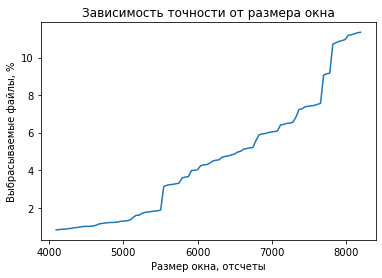

In [18]:
plt.plot(var_len,[res[k][1] for k in range(len(res))])
plt.xlabel('Размер окна, отсчеты')
plt.ylabel('Выбрасываемые файлы, %')
plt.title('Зависимость точности от размера окна')
plt.grid

Наблюдается квадратичный рост. Возьмем размер окна 8192.

In [34]:
len(lengths)-res[-1][1]/100*len(lengths) # Количество файлов, которые надо оставить на рассмотрение

27310.0

In [47]:
len(idxs[-1]) # Количество файлов, которые нужно отбросить

3496